# Playing with Born layers

I envision using Born layers instead of classical MLP ones to perform classification.
Thus, this notebook serves to familiarise me with them and to test a few hypotheses.

In [1]:
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from time import time

import matplotlib.pyplot as plt 
import seaborn as sns

import numpy as np
import pandas as pd

from bornrule.torch import Born

## Dataset creation

In [2]:
def create_dataset(n_samples=10000, n_features=50, n_informative=15, n_redundant=10, n_clusters_per_class=3, class_sep=0.8, n_classes=3):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                               n_redundant=n_redundant, n_clusters_per_class=n_clusters_per_class,
                               class_sep=class_sep, n_classes=n_classes, random_state=42)
    
    # need non-negative features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    # add noise
    X += np.random.normal(0, 0.05, X.shape)
    X = np.clip(X, 0, 1)
    
    # add non-linearity
    X = np.column_stack([X, np.sin(X[:, 0] * X[:, 1] * np.pi)])
    X = np.column_stack([X, np.exp(X[:, 2] * X[:, 3])])
    X = np.column_stack([X, np.log1p(X[:, 4] * X[:, 5])])
    
    X, y = shuffle(X, y, random_state=42)
    return X, y

In [3]:
X, y = create_dataset()

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Feature value range: [{X.min():.4f}, {X.max():.4f}]")

Dataset shape: (10000, 53)
Number of classes: 3
Class distribution: [3336 3339 3325]
Feature value range: [0.0000, 2.0860]


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (6000, 53)
Validation set shape: (2000, 53)
Test set shape: (2000, 53)


## Born Layers

In [5]:
# I call this model naive, because it consists of simply concatenating Born layers, as provided by the `bornrule` module
class NaiveBorn(nn.Module):
    def __init__(self, layer_sizes, device=None, dtype=None):
        super(NaiveBorn, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Born(layer_sizes[i], layer_sizes[i+1], device=device, dtype=dtype))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
# normally, in MLP, we do not desire the hidden layers to output probabilites (usually we "normalise" at the end through softmax)
# the layer below returns logits instead of probabilities (it's just a Born layer without the final normalisation)
class BornLogits(nn.Module):
    def __init__(self, in_features, out_features, device=None, dtype=None):
        super(BornLogits, self).__init__()
        self.born = Born(in_features, out_features, device=device, dtype=dtype)
    
    def forward(self, x):
        if self.born.is_complex(self.born.weight.dtype):
            return torch.pow(torch.mm(x, self.born.weight).abs(), 2)
        else:
            real = torch.mm(x, self.born.weight[0])
            imag = torch.mm(x, self.born.weight[1])
            return torch.pow(real, 2) + torch.pow(imag, 2)

In [7]:
class LogitsBorn(nn.Module):
    def __init__(self, layer_sizes, device=None, dtype=None):
        super(LogitsBorn, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 2):
            self.layers.append(BornLogits(layer_sizes[i], layer_sizes[i+1], device=device, dtype=dtype))
        
        # final layer uses the original Born to output probabilities
        self.layers.append(Born(layer_sizes[-2], layer_sizes[-1], device=device, dtype=dtype))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = torch.relu(x)
        return self.layers[-1](x)

## Evaluation

In [8]:
def evaluate_born_mlp(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, batch_size=32, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.LongTensor(y_val).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.LongTensor(y_test).to(device)
    
    start_time = time()
    for _ in range(epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    train_time = time() - start_time
    
    # validation
    model.eval()
    start_time = time()
    with torch.no_grad():
        val_outputs = model(X_val)
        y_val_pred = torch.argmax(val_outputs, dim=1).cpu().numpy()
        val_proba = torch.softmax(val_outputs, dim=1).cpu().numpy()
    
    val_predict_time = time() - start_time
    
    val_accuracy = accuracy_score(y_val.cpu().numpy(), y_val_pred)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val.cpu().numpy(), y_val_pred, average='weighted')
    val_roc_auc = roc_auc_score(y_val.cpu().numpy(), val_proba, multi_class='ovr', average='weighted')
    
    # test
    with torch.no_grad():
        test_outputs = model(X_test)
        y_test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()
    
    test_accuracy = accuracy_score(y_test.cpu().numpy(), y_test_pred)
    
    return {
        'Validation Accuracy': val_accuracy,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall,
        'Validation F1 Score': val_f1,
        'Validation ROC AUC': val_roc_auc,
        'Test Accuracy': test_accuracy,
        'Train Time': train_time,
        'Validation Predict Time': val_predict_time,
        'Validation Confusion Matrix': confusion_matrix(y_val.cpu().numpy(), y_val_pred)
    }

In [9]:
# these are mostly arbitrary: the important thing is that they're set to the same values for both nets for a fair comparison
in_size = 53
out_size = 3
hid_sizes = [48, 32, 24, 16]

sizes = [in_size] + hid_sizes + [out_size]
models = {
    'NaiveBorn': NaiveBorn(sizes),
    'LogitsBorn': LogitsBorn(sizes),
    
}

In [10]:
results = {}
for name, model in models.items():
    results[name] = evaluate_born_mlp(model, X_train, y_train, X_val, y_val, X_test, y_test)
summary = pd.DataFrame(results).T
summary = summary.drop('Validation Confusion Matrix', axis=1)

summary

,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation ROC AUC,Test Accuracy,Train Time,Validation Predict Time
NaiveBorn,0.6775,0.686579,0.6775,0.678468,0.806642,0.6685,15.465114,0.002066
LogitsBorn,0.7035,0.705045,0.7035,0.703433,0.82724,0.7095,12.3643,0.000885


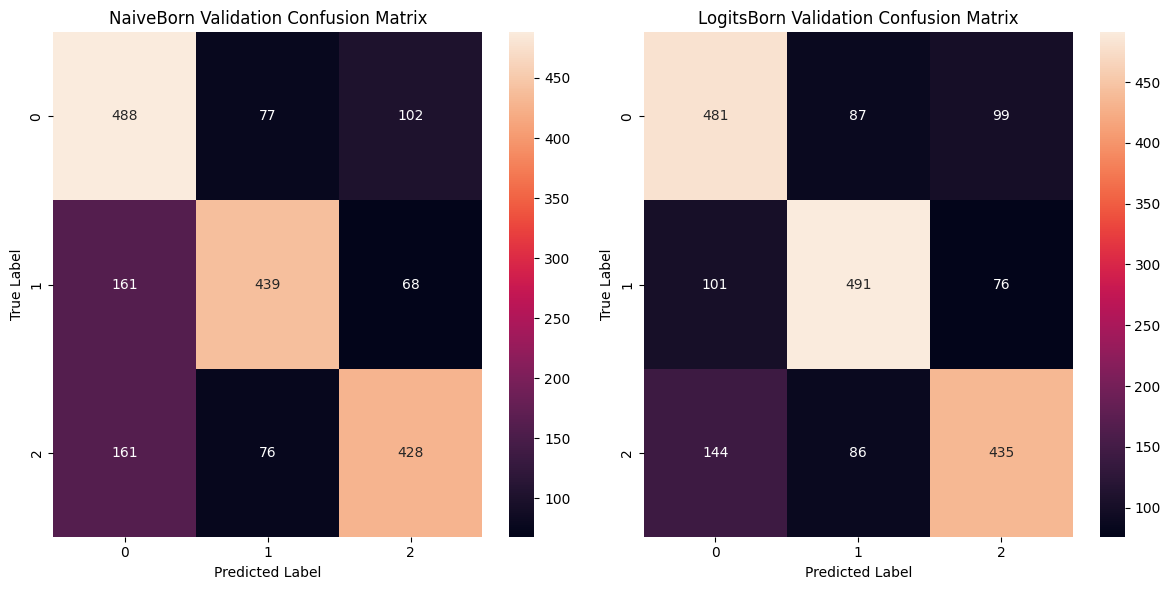

In [11]:
# let's look at the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    sns.heatmap(result['Validation Confusion Matrix'], annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'{name} Validation Confusion Matrix')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Aha! Not bad at all: the deeper we go, the better `LogitsBorn` seems to get (comparatively speaking). 

Not to mention that it is quite a bit faster than its naive counterpart (orders of magnitude faster at predict time!).

We should probably do some further testing to navigate the differences and the options mode in-depth, but we shall skip this step for now...